In [1]:
from fastai.vision.all import *
from fastai.learner import *
from fastai.data.all import *
from fastai.callback.tracker import SaveModelCallback
import pandas as pd
import matplotlib.pyplot as plt
from pathlib2 import Path
import numpy as np
import random
from torch.nn import MSELoss

In [2]:
%%time

df = pd.read_csv('data/examples.csv')
df.shape

CPU times: user 15.5 s, sys: 2.04 s, total: 17.6 s
Wall time: 17.6 s


(14276908, 8)

In [3]:
df.head()

,source_word,target_word,source_fn,target_fn,set_name,speaker_id,book_id,distance_from_target
0,I,FELT,d0af6ad1469446abb6b3b8c98570f139,00ac9fc716964726bc0c17b850c712c0,train-clean-360,7000,83696,1
1,I,THAT,d0af6ad1469446abb6b3b8c98570f139,70f6c024d94549b1a2c19fb42298a8ec,train-clean-360,7000,83696,2
2,FELT,I,00ac9fc716964726bc0c17b850c712c0,d0af6ad1469446abb6b3b8c98570f139,train-clean-360,7000,83696,1
3,FELT,THAT,00ac9fc716964726bc0c17b850c712c0,70f6c024d94549b1a2c19fb42298a8ec,train-clean-360,7000,83696,1
4,FELT,IT,00ac9fc716964726bc0c17b850c712c0,acab1acfa29046c883b4193a4d50a82e,train-clean-360,7000,83696,2


In [4]:
df = df[df.distance_from_target == 1]
df = df[(~df.target_word.isna() & ~df.source_word.isna())]
df.reset_index(inplace=True, drop=True)

In [5]:
words = np.concatenate((df.target_word, df.source_word))
vocab = np.unique(words)

In [6]:
len(vocab)

64763

In [7]:
vocab = list(df.target_word.unique())

In [8]:
# %%time

# uniq_fns = np.unique(df.target_fn.values)
# fn2feature = {}
# for fn in uniq_fns:
#     ary = pd.read_pickle(f'data/examples/{fn}.pkl')
#     fn2feature[fn] = ary

# pd.to_pickle(fn2feature, 'data/fn2feature.pkl')

In [9]:
%%time
fn2features = pd.read_pickle('data/fn2feature.pkl')

CPU times: user 16.6 s, sys: 11.2 s, total: 27.8 s
Wall time: 27.8 s


In [10]:
dataset_mean = -5
dataset_std = 15

def normalize_data(ary):
    return (ary - dataset_mean) / dataset_std

In [11]:
def empty_list(): return list()

In [12]:
# %%time

# word2row_idxs = defaultdict(empty_list)

# for idx, row in df.iterrows():
#     word2row_idxs[row.source_word].append(idx)
    
# pd.to_pickle(word2row_idxs, 'data/word2row_idxs.pkl')

In [13]:
word2row_idxs = pd.read_pickle('data/word2row_idxs.pkl')

In [14]:
def prepare_features(fn, pad_to=291, pad_left=False):
    ary = fn2features[fn][:pad_to]
    example = np.zeros((pad_to, 13))
    if pad_left:
        example[-ary.shape[0]:, :] = ary
    else: example[:ary.shape[0], :] = ary
    return example.astype(np.float32)

In [15]:
class Dataset():
    def __init__(self, df):
        self.df = df
    def __len__(self):
        return self.df.shape[0]
    def __getitem__(self, idx):
        source_word = self.df.source_word[idx]
        target_word = self.df.target_word[idx]
        return vocab.index(self.df.source_word[idx]), vocab.index(self.df.target_word[idx])

In [16]:
train_examples = df[df.set_name.isin(['train-clean-360', 'train-clean-100', 'dev-clean'])]
valid_examples = df[df.set_name == 'test-clean']

train_examples.reset_index(inplace=True, drop=True)
valid_examples.reset_index(inplace=True, drop=True)

In [17]:
train_ds = Dataset(train_examples)
valid_ds = Dataset(valid_examples)

In [18]:
len(train_ds), len(valid_ds)

(7754734, 87118)

In [19]:
BS = 2048
NUM_WORKERS = 8

train_dl = DataLoader(train_ds, BS, NUM_WORKERS, shuffle=True)
valid_dl = DataLoader(valid_ds, BS, NUM_WORKERS)

dls = DataLoaders(train_dl, valid_dl)

In [20]:
class Model(Module):
    def __init__(self, hidden_size=50):
        self.embeddings =nn.Embedding(len(vocab), hidden_size)
        self.linear = nn.Linear(hidden_size, len(vocab))
            
    def forward(self, x):
        x = self.embeddings(x)
        return self.linear(x)

In [21]:
learn = Learner(
    dls.cuda(),
    Model().cuda(),
    loss_func=CrossEntropyLossFlat(),
    opt_func=Adam,
    metrics=[accuracy]
)

In [ ]:
learn.fit(120, lr=1e-3, cbs=SaveModelCallback(fname='text_embeddings', every_epoch=True))

I trained the model above but my laptop disconnected and the training results didn't update. But that is not a worry! We can use the training checkpoints to reconstruct both the loss as well as performance on the semantic tasks after every epoch!

In [74]:
%%capture

val_losses, accuracies, task_perf = [], [], []
for i in range(120):
    learn.load(f'text_embeddings_{i}')
    loss, accuracy = learn.validate()
    val_losses.append(loss)
    accuracies.append(accuracy)
    
    embeddings = learn.model.embeddings.weight.cpu().detach().numpy()
    our_embeddings = Embedding(
        Vocabulary([w.lower() for w in vocab]),
        embeddings
    )

    task_perf.append([evaluate_similarity(our_embeddings, data.X, data.y) for name, data in iteritems(tasks)])

In [75]:
men, ws353, simlex999 = list(zip(*task_perf))

In [76]:
import matplotlib.pyplot as plt

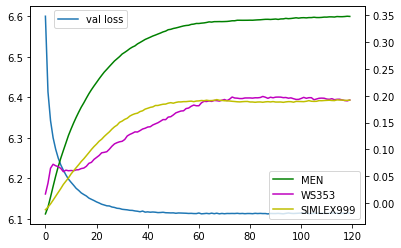

In [96]:
fig, ax1 = plt.subplots()

ax1.plot(val_losses, label='val loss')

ax2 = ax1.twinx()
ax2.plot(men, label='MEN', c='g')
ax2.plot(ws353, label='WS353', c='m')
ax2.plot(simlex999, label='SIMLEX999', c='y')

ax1.legend(loc=[0.07, 0.9])
ax2.legend()

## Evalute embeddings

In [36]:
from utils import Embeddings

In [37]:
embeddings = learn.model.embeddings.weight.cpu().detach().numpy()

In [38]:
word2embedding_without_nans= {}
nans_encountered = 0
for i in range(len(vocab)):    
    if vocab[i] == vocab[i]:
        word2embedding_without_nans[vocab[i]] = embeddings[i]
    else: nans_encountered += 1

print(f'Encountered rows with nan values: {nans_encountered}')

Encountered rows with nan values: 0


In [39]:
e = Embeddings(
    np.array(list(word2embedding_without_nans.values())),
    [w.lower() for w in list(word2embedding_without_nans.keys())]
)

In [40]:
for w in ['fast', 'lost', 'small', 'true', 'crazy', 'slow']:
    print(f'{w}: {e.nn_words_to(e[w])}')

fast: ['fast', 'promiscuously', 'heavily', 'lightly', 'rapidly']
lost: ['lost', 'spoiled', 'learnt', 'spent', 'confided']
small: ['small', 'large', 'big', 'huge', 'tiny']
true: ['true', 'probable', 'gratifying', 'noble', 'obvious']
crazy: ['crazy', 'deaf', 'unborn', 'sick', 'blind']
slow: ['slow', 'quick', 'swift', 'brisk', 'rapid']


## Evaluating embeddings using [word-embeddings-benchmarks](https://github.com/kudkudak/word-embeddings-benchmarks)

In [41]:
import logging
from six import iteritems
from web.datasets.similarity import fetch_MEN, fetch_WS353, fetch_SimLex999
from web.embeddings import fetch_GloVe
from web.evaluate import evaluate_similarity
from web.embedding import Embedding, Vocabulary
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [42]:
tasks = {
    "MEN": fetch_MEN(),
    "WS353": fetch_WS353(),
    "SIMLEX999": fetch_SimLex999()
}

In [43]:
our_embeddings = Embedding(
    Vocabulary([w.lower() for w in list(word2embedding_without_nans.keys())]),
    np.array(list(word2embedding_without_nans.values()))
)

speech2vec = KeyedVectors.load_word2vec_format('../speech2vec-pretrained-vectors/speech2vec/50.vec', binary=False) 
speech2vec_embeddings = Embedding(Vocabulary(list(speech2vec.vocab.keys())), speech2vec.vectors)

In [34]:
for name, data in iteritems(tasks):
    print("Spearman correlation of scores on {} {}".format(name, evaluate_similarity(our_embeddings, data.X, data.y)))

Missing 254 words. Will replace them with mean vector
Missing 50 words. Will replace them with mean vector
Missing 11 words. Will replace them with mean vector


Spearman correlation of scores on MEN 0.3477530214074017
Spearman correlation of scores on WS353 0.19194924096308286
Spearman correlation of scores on SIMLEX999 0.19173815515551154


In [35]:
for name, data in iteritems(tasks):
    print("Spearman correlation of scores on {} {}".format(name, evaluate_similarity(speech2vec_embeddings, data.X, data.y)))

Missing 392 words. Will replace them with mean vector
Missing 61 words. Will replace them with mean vector
Missing 24 words. Will replace them with mean vector


Spearman correlation of scores on MEN 0.5896756323911225
Spearman correlation of scores on WS353 0.49890235673392536
Spearman correlation of scores on SIMLEX999 0.28202624769092116
